In [1]:
import importlib
import esco_utils as eu
import pandas as pd
import json
import matplotlib.pyplot as plt

importlib.reload(eu)

API_TOKEN = eu.get_token()
client = eu.Client(API_TOKEN)

client.api.base_api_url = 'http://flask_sdk:6221'

{'data': {'token': '12a1bad0-4cb1-464c-8c8e-344957672bef'}, 'message': 'successful', 'meta': {}}


In [4]:
tags, pred_stats, user_stats = eu.get_stats(client)
pred_stats.to_csv('data/pred_stats.csv')
user_stats.to_csv('data/user_stats.csv')
tags.to_csv('data/tags.csv')

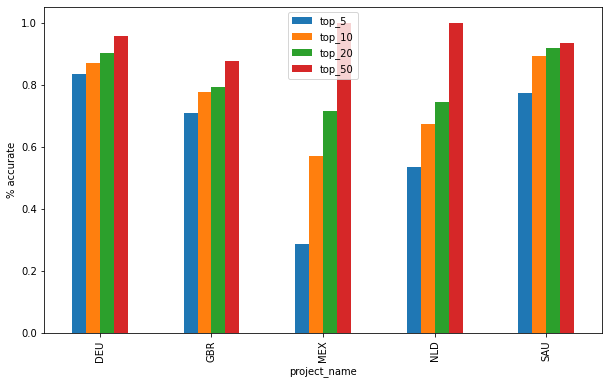

In [10]:
df = tags.groupby('project_name')[['top_5','top_10','top_20','top_50']].mean()
df.plot.bar(figsize=( 10,6))
plt.ylabel('% accurate');

In [54]:
tags, pred_stats, user_stats = eu.get_stats(client)